In [1]:
TRAIN_TFRECORD = '../data/cifar10-train.tfrecord'
SCALING = 'linear'
FRACTION = 5
TOTAL_SAMPLES = 30000
LABELED_SAMPLES = '10:20:30:40:100:250:1000:4000'
SEED = 12345
OUTPUT_DIR = '/home/users/daniel/tmp/'
NAME = 'cifar10'

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as pl

from tqdm import tqdm
from itertools import count
from pathlib import Path

In [3]:
def get_class(serialized_example):
    return tf.parse_single_example(serialized_example, features={'label': tf.FixedLenFeature([], tf.int64)})['label']

dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD).map(get_class)
it = dataset.make_one_shot_iterator().get_next()
class_ids = []
try:
    with tf.Session() as session:
        for n in tqdm(count()):
            result = session.run(it)
            class_ids.append(result)
except tf.errors.OutOfRangeError:
    pass



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


50000it [00:10, 4776.39it/s]


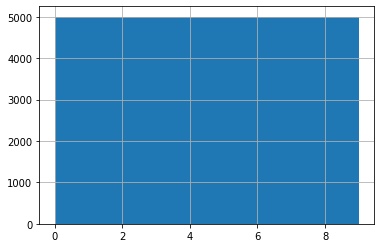

In [4]:
df = pd.DataFrame({'class_id': class_ids})
df.class_id.hist()

In [5]:
def select_num_samples():
    n_classes = df.class_id.max() + 1
    class_order = np.arange(n_classes)
    np.random.shuffle(class_order)

    if SCALING == 'linear':
        num_samples = np.linspace(1, 1 / FRACTION, num=n_classes)
    else:
        raise ValueError(f'Dont understand scaling == {linear}') 

    num_samples *= TOTAL_SAMPLES / np.sum(num_samples)
    num_samples = num_samples[class_order].astype(np.int64)
    
    if any(df.groupby('class_id').size().values < num_samples):
        raise ValueError('Cannot fullfill samples')
    return num_samples

In [6]:
dataset = tf.data.TFRecordDataset(TRAIN_TFRECORD)
it = dataset.make_one_shot_iterator().get_next()
data = []
try:
    with tf.Session() as session:
        for n in tqdm(count()):
            result = session.run(it)
            data.append(result)
except tf.errors.OutOfRangeError:
    pass

50000it [00:08, 6239.79it/s]


In [7]:
output_dir = Path(OUTPUT_DIR) / 'SSL2'
output_dir.mkdir(exist_ok=True, parents=True)

def write_selection(selection, path):
    print(f'Writing to {path}')
    indices = selection['index'].values.copy()
    np.random.shuffle(indices)

    with tf.python_io.TFRecordWriter(str(path)) as writer:
        for index in tqdm(indices):
            writer.write(data[index])

In [8]:
def resample(df, size):
    repeats = size // len(df)
    crops = size % len(df)
    new = pd.concat(repeats * [df] + [df.iloc[:crops]])
    assert len(new) == size
    return new

def resample_classes(df):
    max_count = df.groupby('class_id').size().max()
    return df.groupby('class_id').apply(lambda df: resample(df, max_count)).reset_index(drop=True)

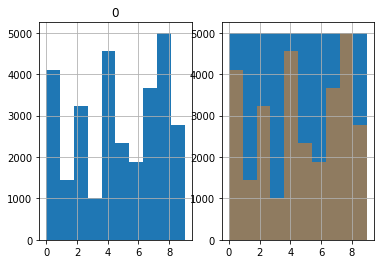

 31%|███       | 15497/50000 [00:00<00:00, 154959.06it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.0-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 136093.64it/s]


Writing to /home/users/daniel/tmp/SSL2/cifar10.0@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.0@4000-label.tfrecord


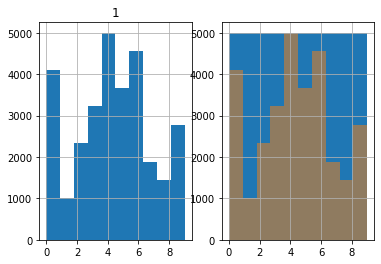

 32%|███▏      | 16239/50000 [00:00<00:00, 162380.48it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.1-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 135181.30it/s]


Writing to /home/users/daniel/tmp/SSL2/cifar10.1@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.1@4000-label.tfrecord


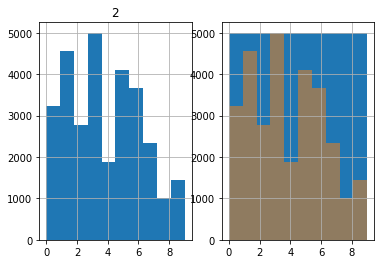

 31%|███       | 15434/50000 [00:00<00:00, 154339.78it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.2-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 150912.24it/s]


Writing to /home/users/daniel/tmp/SSL2/cifar10.2@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.2@4000-label.tfrecord


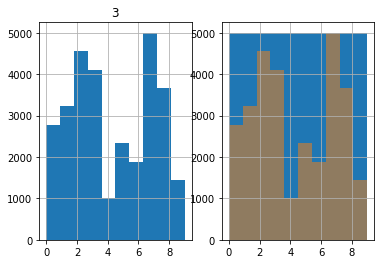

 31%|███       | 15325/50000 [00:00<00:00, 153239.55it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.3-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 149480.26it/s]


Writing to /home/users/daniel/tmp/SSL2/cifar10.3@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.3@4000-label.tfrecord


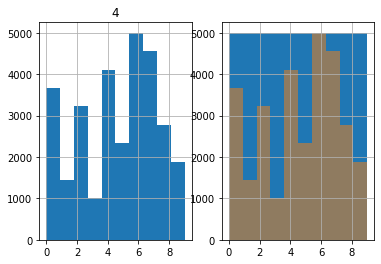

 25%|██▌       | 12577/50000 [00:00<00:00, 125767.72it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.4-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 149910.34it/s]


Writing to /home/users/daniel/tmp/SSL2/cifar10.4@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.4@4000-label.tfrecord


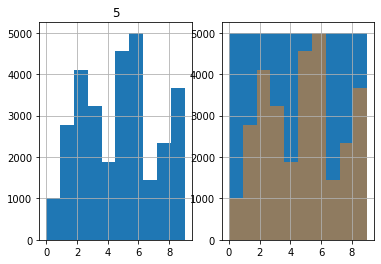

 33%|███▎      | 16353/50000 [00:00<00:00, 163527.82it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.5-unlabel.tfrecord


100%|██████████| 4000/4000 [00:00<00:00, 156988.61it/s]

Writing to /home/users/daniel/tmp/SSL2/cifar10.5@10-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@20-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@30-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@40-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@100-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@250-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@1000-label.tfrecord
Writing to /home/users/daniel/tmp/SSL2/cifar10.5@4000-label.tfrecord


In [9]:
def write_dataset(seed):
    np.random.seed(seed)
    num_samples = select_num_samples()
    
    def sample(group):
        class_id, = group.class_id.unique()
        n = num_samples[class_id]
        return group.sample(n=num_samples[class_id], replace=False)
    
    # Unlabelled dataset pool
    pl.subplot(121)
    selection = df.reset_index().groupby('class_id').apply(sample).reset_index(drop=True)
    selection.class_id.hist()
    pl.title(f'{seed}')

    pl.subplot(122)
    selection_resampled = resample_classes(selection)
    selection_resampled.class_id.hist()
    selection_resampled.drop_duplicates(['index'], keep='first').class_id.hist(alpha=.5)
    pl.show()

    write_selection(selection_resampled, output_dir / f'{NAME}.{seed}-unlabel.tfrecord')
        
    # Labelled examples
    rgen = np.random.RandomState(seed)
    n_classes = df.class_id.max() + 1
 
    for labelled_samples in LABELED_SAMPLES.split(':'):
        n = int(labelled_samples) // n_classes
        selection = df.reset_index().groupby('class_id').apply(
            lambda d: d.sample(n=n, replace=False, random_state=rgen)).reset_index(drop=True)
        write_selection(selection, output_dir / f'{NAME}.{seed}@{labelled_samples}-label.tfrecord')
        
for seed in range(6):
    write_dataset(seed)